<a href="https://colab.research.google.com/github/escaduto/FireSpread/blob/master/FireTrends_WesternUS_07082020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Trends in the Western US

## Setup Connection to Drive

In [1]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
%cd "/content/drive/My Drive/FireDrivers_Paper" 

import os
rootPath = "/content/drive/My Drive/FireDrivers_Paper"
os.chdir(rootPath)

/content/drive/My Drive/FireDrivers_Paper


In [10]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       26751744 kB


## Import Packages

In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express"

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import rtree

In [12]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext):
              file_list.append(os.path.join(path,names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath 

## Interagency Perimeters

### Data Acquisition 

NearTime Perimeters (Current 7days): 

API: https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Public_Wildfire_Perimeters_View/FeatureServer/0/query?outFields=*&where=1%3D1

Archived Wildfire Perimeters 2019-2020:

API: https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Archived_Wildfire_Perimeters2/FeatureServer/0/query?outFields=*&where=1%3D1

Historic Perimeters (2000-2018): 
API: 
https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query?outFields=*&where=1%3D1


### Pre-processing 

In [20]:
# access perimeter data in Drive
perimeter_path = 'data/'

fire_per = lstFiles(perimeter_path, '.shp')
fire_per

['data/WesternUS/GeoMac_2000_2018/US_HIST_FIRE_PERIMTRS_2000_2018_DD83.shp',
 'data/WesternUS/GeoMac_2019/US_HIST_FIRE_PERIM_2019_dd83.shp',
 'data/California/FRAP_Perimeters_ALL.shp']

In [332]:
gmc_00_18 = gpd.read_file(fire_per[0]) # 2018-12-11 to 2000-01-01 
gmc_19 = gpd.read_file(fire_per[1]) # 2019-05-15 to 2020-05-05
frp_all = gpd.read_file(fire_per[2]) # 2020-04-01 to 2020-06-11
gmc_19_filt = gmc_19.groupby(['uniquefire','state']).apply(lambda x: x.loc[x.gisacres.idxmax()])

gmc_frames = [gmc_00_18, gmc_19_filt]
gmc_00_19 = pd.concat(gmc_frames)

In [333]:
stateList =('AZ', 'CA', 'CO', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY')

In [334]:
gmc_00_19_ca = gmc_00_19[gmc_00_19.state=='CA'] 
gmc_00_19_westUS = gmc_00_19[gmc_00_19.state.isin(stateList)]

In [335]:
frp_all = frp_all.dropna(subset=['YEAR_'])
frp_all['Year'] = frp_all['YEAR_'].astype('int64')
frp_00_19_ca = frp_all[frp_all.Year.between(2000, 2019, inclusive=True)]

In [336]:
print("Fires in Western US (2000-2019) ")
print("GeoMac:", len(gmc_00_19_westUS))

print("Fires in CA (2000-2019)")
print("GeoMac:", len(gmc_00_19_ca))
print("FRAP:", len(frp_00_19_ca))

Fires in Western US (2000-2019) 
GeoMac: 19260
Fires in CA (2000-2019)
GeoMac: 4573
FRAP: 6336


In [337]:
gmc_00_19_westUS['Source'] = 'GeoMac'
gmc_00_19_ca['Source'] = 'GeoMac'
frp_00_19_ca['Source'] = 'FRAP'

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [66]:
# gmc_00_19_ca = gmc_00_19_ca[['incidentna', 'state', 'perimeterd', 'fireyear', 
#               'Source', 'gisacres','geometry']]

# frp_00_19_ca = frp_00_19_ca[['FIRE_NAME', 'STATE', 'ALARM_DATE', 'Year', 'Source',
#               'GIS_ACRES', 'geometry']]

In [338]:
def renameColumns(df, original, changeto):
  df = df[original]
  df = df.rename(columns=dict(zip(original, changeto)))
  return df 

In [339]:
gmc_original = ['incidentna', 'state', 'perimeterd', 'fireyear', 
              'Source', 'gisacres','geometry']
              
frp_original = ['FIRE_NAME', 'STATE', 'ALARM_DATE', 'Year', 'Source',
              'GIS_ACRES', 'geometry']

change_names = ['Fire', 'State', 'Date', 'Year', 'Source',
              'Acres', 'geometry']

In [340]:
gmc_00_19_westUS = renameColumns(gmc_00_19_westUS, gmc_original, change_names)
gmc_00_19_ca = renameColumns(gmc_00_19_ca, gmc_original, change_names)
frp_00_19_ca = renameColumns(frp_00_19_ca, frp_original, change_names)

Western US >> Geomac only 
ALL fires vs > 500 acres

Total Acres + Count by mnth.yr

gmc_00_19_westUS

<br><br>
CA >> Geomac vs FRAP (Source Type)

Total Acres + Count by mnth.yr.source

frp_00_19_ca, gmc_00_19_ca 

In [341]:
gmc_00_19_westUS = gmc_00_19_westUS.sort_values('Year')
gmc_00_19_westUS = gmc_00_19_westUS[gmc_00_19_westUS['Year'].isin(range(2000, 2020))]

In [342]:
gmc_sum = gmc_00_19_westUS.groupby('Year').agg({'Fire': 'count'}).reset_index()

In [343]:
gmc_00_19_westUS_LARGE = gmc_00_19_westUS[gmc_00_19_westUS['Acres'] >= 500]

In [344]:
gmc_year_sum = gmc_00_19_westUS_LARGE.groupby('Year').agg({'Acres': ['sum'], 'Fire': 'count'}).reset_index()
gmc_year_sum.columns = ['Year', 'Total Acres', 'Fire Count']

In [345]:
countvals = gmc_00_19_westUS_LARGE.groupby('Year')['Fire'].nunique().reset_index()
countvalslst = countvals['Fire'].values.tolist()

In [346]:
def addDateAttributes(df, dateColumn, yr_range, mnth_range):
  # create column for year, month, day 
  df[dateColumn]= pd.to_datetime(df[dateColumn], format='%Y-%m-%d')
  df['Year'] = df[dateColumn].dt.strftime('%Y').astype('int64')
  df['Month'] = df[dateColumn].dt.strftime('%m').astype('int64')
  df['Day'] = df[dateColumn].dt.strftime('%d').astype('int64')
  df['JD'] = df[dateColumn].dt.strftime('%j').astype('int64')
  df['Week'] = df[dateColumn].apply(lambda x: "%d" % (x.week)).astype('int64')
  # filter by year
  df = df[df.Year.isin(yr_range)]
  df = df[df.Month.isin(mnth_range)]
  return df

In [347]:
yr_range = range(2000, 2021)
mnth_range = range(1, 12)

In [348]:
gmc_00_19_westUS_LARGE = addDateAttributes(gmc_00_19_westUS_LARGE, 'Date', 
                   yr_range, mnth_range)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


### Western US Fires

In [358]:
gmc_00_19_westUS_LARGE.head()

yr_range = range(2012, 2020)
mnth_range = range(1, 12)
gmc_12_19_westUS_LARGE = gmc_00_19_westUS_LARGE[(gmc_00_19_westUS_LARGE.Year.isin(yr_range) &
                                                 (gmc_00_19_westUS_LARGE.Month.isin(mnth_range)))]

In [359]:
fire_by_yr = gmc_12_19_westUS_LARGE.groupby(['State','Year', 'Week']).agg({'Fire': 'count', 'Acres': ['sum', 'mean', 'std']}).reset_index()
fire_by_yr.columns = ['State', 'Year', 'Week', 'Count', 'Total (Acres)', 'Mean (Acres)', 'Stdv (Acres']
fire_by_yr['Year'] = fire_by_yr['Year'].astype('int64')
fire_by_yr['Year'] = fire_by_yr['Year'].astype('str')
fire_by_yr

,State,Year,Week,Count,Total (Acres),Mean (Acres),Stdv (Acres
0,AZ,2012,12,1,1981.795399,1981.795399,NaN
1,AZ,2012,18,1,1704.086287,1704.086287,NaN
2,AZ,2012,20,2,3735.736984,1867.868492,391.709450
3,AZ,2012,21,1,16080.245275,16080.245275,NaN
4,AZ,2012,22,1,16218.632302,16218.632302,NaN
...,...,...,...,...,...,...,...
1086,WY,2018,38,2,5885.282900,2942.641450,1185.442672
1087,WY,2018,39,1,6496.470430,6496.470430,NaN
1088,WY,2018,40,1,61567.565252,61567.565252,NaN
1089,WY,2019,33,1,1349.241505,1349.241505,NaN


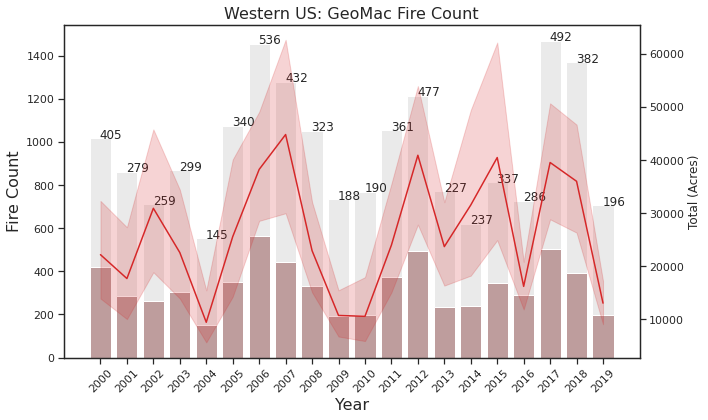

In [352]:
import seaborn as sns
sns.set(style='ticks')
# Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
# bar plot creation
ax1.set_title('Western US: GeoMac Fire Count', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Count', fontsize=16)
ax1 = sns.barplot(x='Year', y = 'Fire', data = gmc_sum, color='#eaeaea')
ax1.tick_params(axis='y')
ax1 = sns.barplot(x='Year', y = 'Fire Count', data = gmc_year_sum, color='#c39797')

for p, label in zip(ax1.patches, countvalslst):
    ax1.annotate(label, (p.get_x()+0.375, p.get_height()+0.15))

ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
# #line plot creation
#ax2.set_ylabel('Area Burned', fontsize=16)
ax2 = sns.lineplot(x='Year', y='Total (Acres)', data = fire_by_yr, sort=False, color=color)
#ax2 = sns.lineplot(x='Year', y='Total Acres', data=gmc_year_sum, color=color)
#ax2.tick_params(axis='y', color=color)

plt.tight_layout()
plt.savefig('Figures/WesternUS_Count.png', dpi = 400)

In [360]:
fire_by_yr = fire_by_yr.sort_values(by=['State','Year', 'Week'])

In [369]:

sample = fire_by_yr[['State', 'Year', 'Total (Acres)']]

table = pd.pivot_table(sample, values='Total (Acres)', index=['State'],
                    columns=['Year']).reset_index()

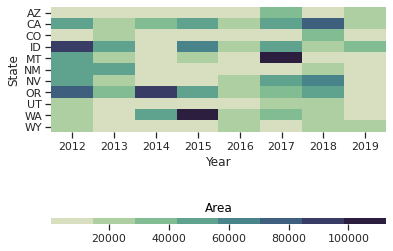

In [368]:
import seaborn as sns
sns.set(style='ticks')
state_y = ['AZ', 'CA', 'CO', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

grid_kws = {"height_ratios": (1, 0.05), "hspace": 1.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(table, ax=ax, cmap= sns.cubehelix_palette(8, start=.5, rot=-.75),
                 cbar_ax=cbar_ax, yticklabels = state_y, 
                 cbar_kws={"orientation": "horizontal"})

plt.title('Area', color='black')
plt.savefig('Figures/Interagency_Area_HeatMap_LargeFires_1219.png', dpi = 400)

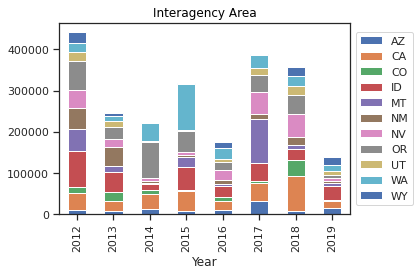

In [370]:
table.set_index('State').T.plot(kind='bar', stacked=True)
plt.title('Interagency Area', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig('Figures/Interagency_Area_stackedbar_LargeFires_1219.png', dpi = 400)

## California


In [372]:
gmc_00_19_ca.head()

,Fire,State,Date,Year,Source,Acres,geometry
7,WHALEBACK,CA,2018-08-05,2018,GeoMac,18701.898412,"MULTIPOLYGON (((-120.78563 40.67675, -120.7857..."
10,DOUBLE,CA,2013-08-16,2013,GeoMac,64.273666,"POLYGON ((-122.48004 39.01807, -122.48023 39.0..."
18,THOMAS,CA,2017-12-27,2017,GeoMac,281893.756972,"MULTIPOLYGON (((-119.42465 34.63699, -119.4243..."
64,SOUP 5,CA,2016-09-19,2016,GeoMac,0.086849,"POLYGON ((-120.28226 41.28389, -120.28235 41.2..."
72,PLEASANT,CA,2018-02-23,2018,GeoMac,2076.568139,"MULTIPOLYGON (((-118.42576 37.41812, -118.4254..."


In [374]:
frp_00_19_ca.head()

,Fire,State,Date,Year,Source,Acres,geometry
0,OCTOBER,CA,2007-10-21,2007,FRAP,25.7367,"POLYGON ((138036.906 -402646.363, 138086.986 -..."
1,MAGIC,CA,2007-10-22,2007,FRAP,2824.8800,"POLYGON ((130072.487 -398622.842, 130094.237 -..."
2,RANCH,CA,2007-10-20,2007,FRAP,58410.3000,"POLYGON ((114013.974 -379231.746, 114190.835 -..."
3,EMMA,CA,2007-09-11,2007,FRAP,172.2150,"POLYGON ((176902.236 -388673.082, 176907.996 -..."
4,CORRAL,CA,2007-11-24,2007,FRAP,4708.0000,"POLYGON ((115905.006 -436381.137, 115926.897 -..."


In [391]:
# merge ca fires datasets 

ca_frames = [gmc_00_19_ca, frp_00_19_ca]
CA_00_19 = pd.concat(ca_frames)
CA_00_19_LARGE = CA_00_19[CA_00_19['Acres'] >= 500]

In [401]:
CA_00_19_LARGE['Size'] = 'Large (>50 acres)'
CA_00_19['Size'] ='All'

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [402]:
ca_frames = [CA_00_19_LARGE, CA_00_19]
CA_00_19_size = pd.concat(ca_frames)
CA_00_19_size = CA_00_19_size.sort_values(by=['Year'])

In [403]:
CA_00_19_size = CA_00_19_size[CA_00_19_size['Year'].isin(range(2000, 2020))]

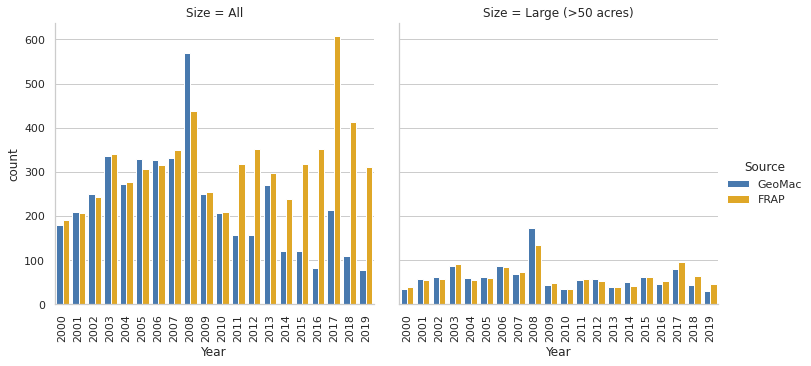

In [407]:
sns.set(style='whitegrid')
colors = ["windows blue", "amber"]
palette = sns.xkcd_palette(colors)

g = sns.catplot(x="Year", kind = "count",
            hue='Source', col="Size",palette=palette,
            data=CA_00_19_size)


g.set_xticklabels(rotation=90)
plt.savefig('Figures/Interagency_comparison_1219.png', dpi = 400)